In [329]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

In [330]:
model_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\lightgbm_encoded_shuffled_zscore2.pkl"
dataset_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\encoded_shuffled.csv"
graph_trial_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\separate_samples\graph_trial.xlsx"

## Test Data Creation for Visualization



In [331]:
# CSV dosyasını oku
overall_data = pd.read_csv(dataset_path)

# Boş DataFrame oluştur (Aynı sütunlarla)
empty_excel = pd.DataFrame(columns=overall_data.columns)

# "sample" sütununda "cel" içeren satırları filtrele
filtered_data = overall_data

# Filtrelenmiş veriyi empty_excel'e ekle
empty_excel = filtered_data.copy()  # Tüm sütu

In [332]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [333]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
# Feature Engineering
empty_excel['oh'] = empty_excel['o'] / empty_excel['h']
empty_excel['T_time'] = empty_excel['residence_time'] * empty_excel['temperature']
empty_excel['t_to_Tset'] = empty_excel['temperature'] / empty_excel['heat_rate']
empty_excel['VM/FC'] = empty_excel['vm'] / empty_excel['fc']
empty_excel['AC/FC'] = empty_excel['ac'] / empty_excel['fc']

# Drop unnecessary columns
empty_excel.drop(['h', 'o', 'c', 'wc', 'lhv', 'vm', 'ac', 'fc'], axis=1, inplace=True)


empty_excel = empty_excel[(empty_excel['x0_biomass'] == 1)& (empty_excel['pressure'] == 1) & (empty_excel['residence_time'] == 1) & (empty_excel['heat_rate'] == 1000)]
empty_excel = remove_outliers(empty_excel, 'devol_yield')
print(empty_excel.describe())
# & (empty_excel['pressure'] == 1) & (empty_excel['residence_time'] == 1) & (empty_excel['heat_rate'] == 1000)
# Define X and y
X_trial = empty_excel.drop(['sample', 'devol_yield'], axis=1)
y_trial = empty_excel[['devol_yield']]  # Keep y as a DataFrame

# Handle missing values using KNN Imputer
imputer = KNNImputer(n_neighbors=3)
X_trial = pd.DataFrame(imputer.fit_transform(X_trial), columns=X_trial.columns)
y_trial = pd.DataFrame(imputer.fit_transform(y_trial), columns=['devol_yield'])

# Standardize Features
scaler = StandardScaler()
X_trial = pd.DataFrame(scaler.fit_transform(X_trial), columns=X_trial.columns)

       temperature  residence_time  pressure  heat_rate           n  \
count   176.000000           176.0     176.0      176.0  176.000000   
mean    741.477273             1.0       1.0     1000.0    1.658199   
std     262.593830             0.0       0.0        0.0    1.431367   
min     200.000000             1.0       1.0     1000.0    0.269662   
25%     600.000000             1.0       1.0     1000.0    0.307391   
50%     800.000000             1.0       1.0     1000.0    0.889846   
75%    1000.000000             1.0       1.0     1000.0    2.400000   
max    1200.000000             1.0       1.0     1000.0    3.900000   

                s          cl          hc          oc  devol_yield  \
count  176.000000  152.000000  176.000000  176.000000   176.000000   
mean     0.635825    1.001566    1.228192    8.171851    47.510573   
std      0.817276    0.637811    0.394438    9.903355    27.281377   
min      0.046420    0.000000    0.461416    0.396065    -2.871983   
25%      0

In [334]:
xgb_model = joblib.load(model_path)

In [335]:
predictions = xgb_model.predict(X_trial)

Scaler saved to saved_models\minmax_scaler.pkl

=== Leaving out fuel: Cellulose ===


C:\Users\demir\PycharmProjects\volatile-predict\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:698: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000136C5AC5730>>
Traceback (most recent call last):
  File "C:\Users\demir\PycharmProjects\volatile-predict\.venv\lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

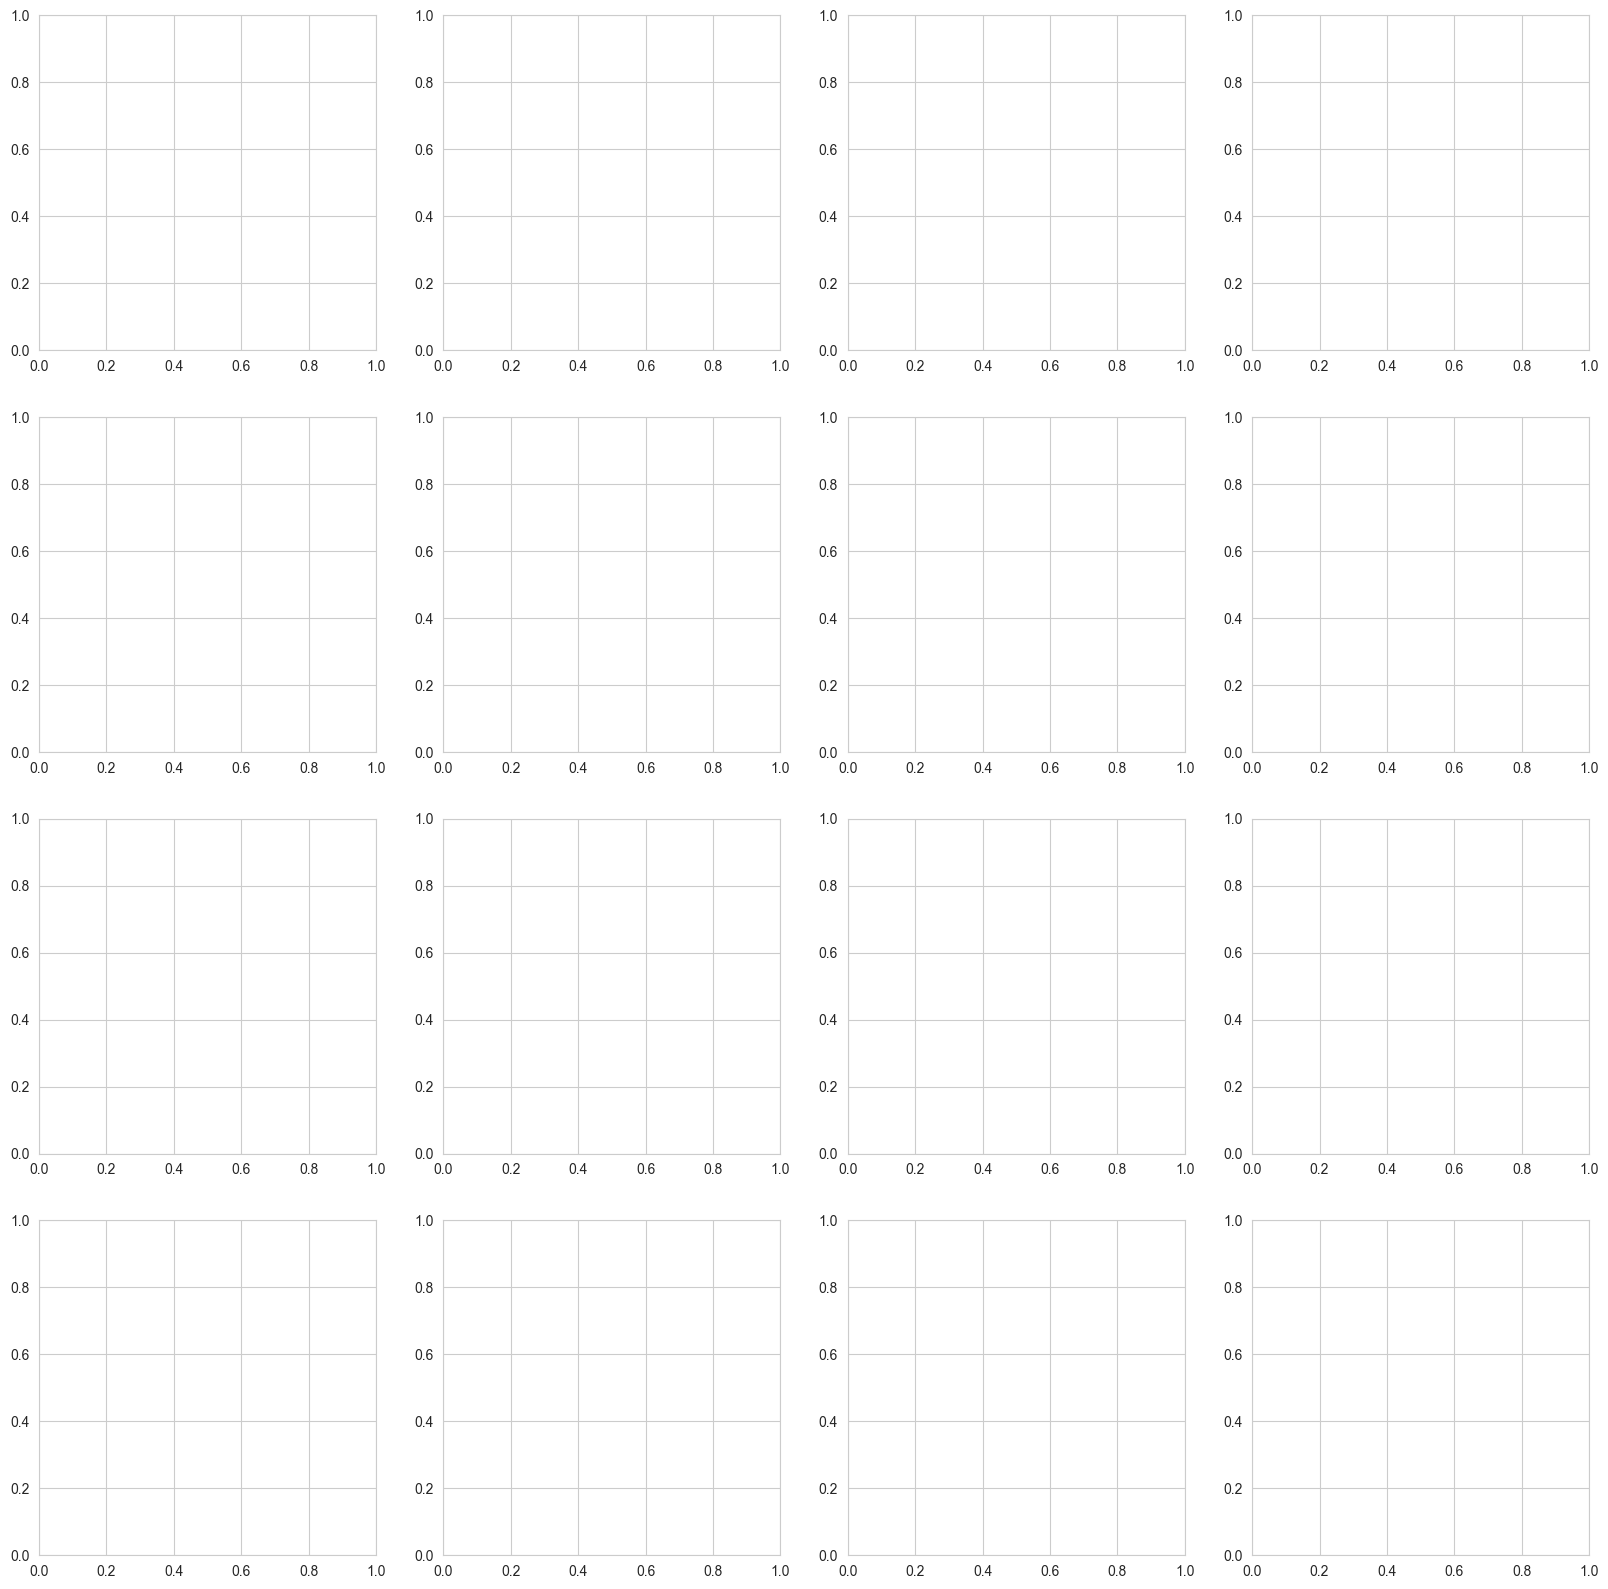

In [2]:
from sklearn.ensemble import VotingRegressor
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler
import joblib
import time
import os
from scipy.stats import randint, uniform

# Create directory for saving models if it doesn't exist
save_dir = "saved_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Load data
data_path = r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Final Results\Final Data Used\final_data_filtered_ohe.csv"
df = pd.read_csv(data_path, delimiter=',')

# Make a copy of the original data for later use in combined plots
df_original = df.copy()

# === Feature Engineering ===
epsilon = 1e-6
df['vm_fc_ratio'] = df['vm'] / (df['fc'] + epsilon)
df['ac_fc_ratio'] = df['ac'] / (df['fc'] + epsilon)
df['n_cl_ratio'] = df['n'] / (df['cl'] + epsilon)

# === Define feature columns ===
feature_cols = [
    'h', 'wc', 'c', 'lhv', 'o', 'n', 's', 'cl',
    'hc', 'oc', 'temperature', 'residence_time', 'pressure', 'heat_rate',
    'vm_fc_ratio', 'ac_fc_ratio', 'n_cl_ratio'
]

# === Expanded bounds for MinMaxScaler ===
min_vm_fc_ratio = df['vm_fc_ratio'].min()
max_vm_fc_ratio = df['vm_fc_ratio'].max()
min_ac_fc_ratio = df['ac_fc_ratio'].min()
max_ac_fc_ratio = df['ac_fc_ratio'].max()
min_n_cl_ratio = df['n_cl_ratio'].min()
max_n_cl_ratio = df['n_cl_ratio'].max()

min_values = {
    'wc': 2.6, 'vm': 44.2, 'fc': 3.064326, 'ac': 0.0, 'c': 32.4, 'h': 3.265 , 'lhv': 13.528,
    'o': 7.0, 'n': 0.269662, 's': 0.04642, 'cl': 0.0, 'hc': 0.7, 'oc': 0.0,
    'temperature': 200, 'residence_time': 0.5, 'pressure': 0.5, 'heat_rate': 10,
    'vm_fc_ratio': min_vm_fc_ratio, 'ac_fc_ratio': min_ac_fc_ratio, 'n_cl_ratio':min_n_cl_ratio
}
max_values = {
    'wc': 10.8, 'vm': 91.735674, 'fc': 44.5, 'ac': 37.52, 'c': 82.3, 'h': 10.13205, 'lhv': 35.8,
    'o': 54.936839, 'n': 3.9, 's': 2.5, 'cl': 1.5, 'hc': 1.857, 'oc': 1.04402,
    'temperature': 1200, 'residence_time': 20, 'pressure': 20, 'heat_rate': 1000,
    'vm_fc_ratio': max_vm_fc_ratio, 'ac_fc_ratio': max_ac_fc_ratio, 'n_cl_ratio': max_n_cl_ratio
}
margin_ratio = 0.4
expanded_bounds = {}
for feat in feature_cols:
    min_val = min_values[feat]
    max_val = max_values[feat]
    range_val = max_val - min_val
    new_min = max(0, min_val - range_val * margin_ratio)
    new_max = max_val + range_val * margin_ratio
    expanded_bounds[feat] = (round(new_min, 3), round(new_max, 3))

X_bounds = pd.DataFrame({col: [expanded_bounds[col][0], expanded_bounds[col][1]] for col in feature_cols})
scaler = MinMaxScaler()
scaler.fit(X_bounds)

# Save scaler for reproducibility
joblib.dump(scaler, os.path.join(save_dir, 'minmax_scaler.pkl'))
print(f"Scaler saved to {os.path.join(save_dir, 'minmax_scaler.pkl')}")

# === Prepare Fuel Types ===
fuel_types = df['fuel_type'].unique()

# === Function to Evaluate Model ===
def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_pred = model.predict(X_test)

    metrics = {
        "Model": model_name,
        "R2": r2_score(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "Training Time (s)": train_time
    }

    return metrics, y_pred, model

# === Models ===
def get_base_models():
    best_mlp = MLPRegressor(hidden_layer_sizes=(100, 100), activation='relu', solver='adam', max_iter=2000, random_state=42)
    best_gbr = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
    best_xgb = xgb.XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
    best_lgb = lgb.LGBMRegressor(n_estimators=300, learning_rate=0.1, max_depth=4, random_state=42)
    best_lasso = Lasso(alpha=1.0)
    best_knn = KNeighborsRegressor(n_neighbors=3, metric='minkowski')

    return best_mlp, best_gbr, best_xgb, best_lgb, best_lasso, best_knn

# === Leave-One-Fuel-Out Cross-Validation ===
results = []
all_parity_data = []  # Store all parity data for tile plots

# Calculate optimal grid size for subplots based on number of fuel types
n_fuels = len(fuel_types)
grid_size = int(np.ceil(np.sqrt(n_fuels)))
fig, axes = plt.subplots(grid_size, grid_size, figsize=(5*grid_size, 5*grid_size))
axes = axes.flatten() if n_fuels > 1 else [axes]

# Main training and evaluation loop
for i, fuel in enumerate(fuel_types):
    print(f"\n=== Leaving out fuel: {fuel} ===")

    # Split
    train_data = df[df['fuel_type'] != fuel]
    test_data = df[df['fuel_type'] == fuel]

    X_train = train_data[feature_cols]
    y_train = train_data['devol_yield']
    X_test = test_data[feature_cols]
    y_test = test_data['devol_yield']

    # Scale and drop features
    X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=feature_cols, index=X_train.index).drop(['wc', 'c', 'o', 'h', 'n', 'cl'], axis=1)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=feature_cols, index=X_test.index).drop(['wc', 'c', 'o', 'h', 'cl', 'n'], axis=1)

    # Get new models for each fold
    best_mlp, best_gbr, best_xgb, best_lgb, best_lasso, best_knn = get_base_models()

    # Voting Regressor
    voting_regressor = VotingRegressor(
        estimators=[
            ('mlp', best_mlp),
            ('gbr', best_gbr),
            ('xgb', best_xgb),
            ('lgb', best_lgb),
            ('lasso', best_lasso),
            ('knn', best_knn)
        ],
        weights=[1,2,2,1,1,0.5]
    )

    # Evaluate
    metrics, y_pred, trained_model = evaluate_model(voting_regressor, f"VotingRegressor - {fuel}", X_train_scaled, y_train, X_test_scaled, y_test)
    results.append((fuel, metrics, y_test, y_pred))

    # Store parity data for this fuel
    all_parity_data.append({
        'fuel': fuel,
        'actual': y_test,
        'predicted': y_pred,
        'r2': metrics['R2'],
        'rmse': metrics['RMSE']
    })

    # Print metrics
    print(f"R2 Score: {metrics['R2']:.4f}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")

    # Save model for this fold
    model_filename = os.path.join(save_dir, f'voting_regressor_{fuel.replace(" ", "_")}.pkl')
    joblib.dump(trained_model, model_filename)
    print(f"Model for fuel '{fuel}' saved to {model_filename}")

    # Plot individual parity plot in the subplot grid
    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.7, edgecolors='k')

    # Add diagonal line (perfect prediction line)
    min_val = min(min(y_test), min(y_pred))
    max_val = max(max(y_test), max(y_pred))
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')

    # Add labels and metrics
    ax.set_xlabel('Actual Values')
    ax.set_ylabel('Predicted Values')
    ax.set_title(f'{fuel}\nR² = {metrics["R2"]:.4f}, RMSE = {metrics["RMSE"]:.4f}')
    ax.grid(True)

# Hide any extra subplots
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join(save_dir, 'all_fuels_parity_plots.png'), dpi=300, bbox_inches='tight')
plt.show()

# === Final Summary Table ===
summary = pd.DataFrame([{
    'Fuel Type': fuel,
    'R2': metrics['R2'],
    'RMSE': metrics['RMSE'],
    'MAE': metrics['MAE'],
    'Train Time (s)': metrics['Training Time (s)']
} for fuel, metrics, _, _ in results])

print("\n=== Summary of One-Fuel-Leave-Out Results ===")
print(summary)

# Save summary results to CSV
summary.to_csv(os.path.join(save_dir, 'lofo_results_summary.csv'), index=False)
print(f"Summary results saved to {os.path.join(save_dir, 'lofo_results_summary.csv')}")

# === Create spline interpolation plots for each fuel ===
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt

# Define standard conditions
std_pressure = 1.0
std_heat_rate = 1000.0
std_residence_time = 1.0

# For each fuel, create a smoothed temperature plot
for fuel in fuel_types:
    print(f"\n=== Creating spline plot for: {fuel} ===")

    # Get data for this fuel
    fuel_data = df_original[df_original['fuel_type'] == fuel]

    if len(fuel_data) == 0:
        print(f"No data available for fuel: {fuel}")
        continue

    # Filter data with conditions close to the specified ones
    filtered_data = fuel_data[
        (np.abs(fuel_data['pressure'] - std_pressure) < 0.5) &
        (np.abs(fuel_data['heat_rate'] - std_heat_rate) < 100) &
        (np.abs(fuel_data['residence_time'] - std_residence_time) < 0.5)
    ]

    filtered_data['vm_fc_ratio'] = filtered_data['vm'] / (filtered_data['fc'] + epsilon)
    filtered_data['ac_fc_ratio'] = filtered_data['ac'] / (filtered_data['fc'] + epsilon)
    filtered_data['n_cl_ratio'] = filtered_data['n'] / (filtered_data['cl'] + epsilon)

    # Check if we have enough data points with the conditions
    condition_str = ""
    if len(filtered_data) < 10:  # Need enough points for reliable binning
        print(f"Not enough data points with specified conditions for {fuel}, using all data")
        filtered_data = fuel_data.copy()
        condition_str = "\n(using all available data)"
    else:
        condition_str = f"\n(Pressure ≈ {std_pressure} bar, Residence Time ≈ {std_residence_time}, Heating Rate ≈ {std_heat_rate} K/s)"

    # If we still don't have data, skip this fuel
    if len(filtered_data) == 0:
        print(f"No data available for fuel: {fuel} after filtering")
        continue

    # Load the model for this fuel
    try:
        model_path = os.path.join(save_dir, f'voting_regressor_{fuel.replace(" ", "_")}.pkl')
        fuel_model = joblib.load(model_path)
    except:
        print(f"Could not load model for fuel: {fuel}")
        continue

    # Group by temperature bins to get average values
    # Create temperature bins (every 50 degrees)
    bin_size = 50
    min_temp = filtered_data['temperature'].min()
    max_temp = filtered_data['temperature'].max()
    bins = np.arange(min_temp - (min_temp % bin_size), max_temp + bin_size, bin_size)

    # Add bin column
    filtered_data['temp_bin'] = pd.cut(filtered_data['temperature'], bins=bins, labels=bins[:-1])

    # Group by temperature bin
    grouped = filtered_data.groupby('temp_bin').agg({
        'temperature': 'mean',
        'devol_yield': 'mean',
        'pressure': 'mean',
        'heat_rate': 'mean',
        'residence_time': 'mean'
    }).reset_index(drop=True)

    # Get features for prediction
    X_grouped = pd.DataFrame()
    for col in feature_cols:
        if col in ['temperature', 'pressure', 'heat_rate', 'residence_time']:
            X_grouped[col] = grouped[col]
        else:
            # For other features, take median from the filtered data
            X_grouped[col] = [filtered_data[col].median()] * len(grouped)

    # Scale data
    X_grouped_scaled = pd.DataFrame(
        scaler.transform(X_grouped),
        columns=feature_cols
    ).drop(['wc', 'c', 'o', 'h', 'cl', 'n'], axis=1)

    # Make predictions
    grouped['predictions'] = fuel_model.predict(X_grouped_scaled)

    # Prepare data for spline interpolation
    # We need at least 4 points for cubic spline
    spline_degree = min(3, len(grouped) - 1) if len(grouped) > 1 else 1

    # Create smooth x values for the plot
    x_smooth = np.linspace(grouped['temperature'].min(), grouped['temperature'].max(), 100)

    # Apply spline interpolation for smoothing if we have enough points
    if len(grouped) >= 4:
        try:
            spline_real = make_interp_spline(grouped['temperature'], grouped['devol_yield'], k=spline_degree)
            spline_pred = make_interp_spline(grouped['temperature'], grouped['predictions'], k=spline_degree)

            y_smooth_real = spline_real(x_smooth)
            y_smooth_pred = spline_pred(x_smooth)

            # Plot the smoothed graph
            plt.figure(figsize=(10, 6))

            # Smoothed real values
            plt.plot(x_smooth, y_smooth_real, color='blue', label='Actual Values', linewidth=2)

            # Smoothed predicted values
            plt.plot(x_smooth, y_smooth_pred, color='red', linestyle='dashed', label='Predicted Values', linewidth=2)

            # Add the actual data points for reference
            plt.scatter(grouped['temperature'], grouped['devol_yield'], color='blue', s=30, alpha=0.7)
            plt.scatter(grouped['temperature'], grouped['predictions'], color='red', s=30, alpha=0.7)

        except Exception as e:
            print(f"Error creating spline for {fuel}: {e}")
            # Fallback to simple line plot
            plt.figure(figsize=(10, 6))
            plt.plot(grouped['temperature'], grouped['devol_yield'], color='blue', label='Actual Values', linewidth=2)
            plt.plot(grouped['temperature'], grouped['predictions'], color='red', linestyle='dashed', label='Predicted Values', linewidth=2)
    else:
        # Not enough points for spline, use simple line plot
        plt.figure(figsize=(10, 6))
        plt.plot(grouped['temperature'], grouped['devol_yield'], 'o-', color='blue', label='Actual Values', linewidth=2)
        plt.plot(grouped['temperature'], grouped['predictions'], 'o--', color='red', label='Predicted Values', linewidth=2)

    plt.title(f"{fuel}\nMean Actual Values vs. Mean Predicted Values{condition_str}")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Devolatilization Yield (%)")
    plt.legend()
    plt.grid(True)

    # Save the plot
    plt.savefig(os.path.join(save_dir, f'spline_plot_{fuel.replace(" ", "_")}.png'), dpi=300, bbox_inches='tight')
    plt.close()

# === Create combined spline plot for all fuels ===
# Group fuels by category (this is optional, if you know the categories)
biomass_fuels = [f for f in fuel_types if 'biomass' in f.lower()]
coal_fuels = [f for f in fuel_types if 'coal' in f.lower()]
other_fuels = [f for f in fuel_types if f not in biomass_fuels and f not in coal_fuels]

# Process fuel categories
for category_name, fuels_list in [("Biomass Fuels", biomass_fuels),
                                  ("Coal Fuels", coal_fuels),
                                  ("Other Fuels", other_fuels),
                                  ("All Fuels", fuel_types)]:

    if not fuels_list:
        continue

    print(f"\n=== Creating combined spline plot for: {category_name} ===")

    # Collect all filtered data for this category
    all_filtered_data = []

    for fuel in fuels_list:
        fuel_data = df_original[df_original['fuel_type'] == fuel]

        if len(fuel_data) == 0:
            continue

        # Filter data with conditions
        filtered_data = fuel_data[
            (np.abs(fuel_data['pressure'] - std_pressure) < 0.5) &
            (np.abs(fuel_data['heat_rate'] - std_heat_rate) < 100) &
            (np.abs(fuel_data['residence_time'] - std_residence_time) < 0.5)
        ]

        # If not enough data with conditions, use all data for this fuel
        if len(filtered_data) < 5:
            filtered_data = fuel_data.copy()

        if len(filtered_data) > 0:
            filtered_data['fuel_type'] = fuel  # ensure we keep track of fuel type
            all_filtered_data.append(filtered_data)

    if not all_filtered_data:
        print(f"No data available for {category_name}")
        continue

    # Combine all filtered data
    combined_data = pd.concat(all_filtered_data, ignore_index=True)

    # Create temperature bins (every 50 degrees)
    bin_size = 50
    min_temp = combined_data['temperature'].min()
    max_temp = combined_data['temperature'].max()
    bins = np.arange(min_temp - (min_temp % bin_size), max_temp + bin_size, bin_size)

    # Add bin column
    combined_data['temp_bin'] = pd.cut(combined_data['temperature'], bins=bins, labels=bins[:-1])

    # Group by temperature bin
    grouped = combined_data.groupby('temp_bin').agg({
        'temperature': 'mean',
        'devol_yield': 'mean',
        'pressure': 'mean',
        'heat_rate': 'mean',
        'residence_time': 'mean'
    }).reset_index(drop=True)

    # Get predictions for each data point
    all_predictions = []

    # Process each fuel type separately for prediction
    for fuel in fuels_list:
        fuel_data = combined_data[combined_data['fuel_type'] == fuel]

        if len(fuel_data) == 0:
            continue

        try:
            model_path = os.path.join(save_dir, f'voting_regressor_{fuel.replace(" ", "_")}.pkl')
            fuel_model = joblib.load(model_path)
        except:
            print(f"Could not load model for fuel: {fuel}")
            continue

        # Get features for this fuel
        X_fuel = fuel_data[feature_cols]

        # Scale data
        X_fuel_scaled = pd.DataFrame(
            scaler.transform(X_fuel),
            columns=feature_cols
        ).drop(['wc', 'c', 'o', 'h', 'cl', 'n'], axis=1)

        # Make predictions
        fuel_data['predictions'] = fuel_model.predict(X_fuel_scaled)
        all_predictions.append(fuel_data)

    if not all_predictions:
        print(f"No predictions could be made for {category_name}")
        continue

    # Combine all predictions
    all_pred_data = pd.concat(all_predictions, ignore_index=True)

    # Group predicted values by temperature bin
    grouped_pred = all_pred_data.groupby('temp_bin').agg({
        'temperature': 'mean',
        'predictions': 'mean'
    }).reset_index(drop=True)

    # Create smooth x values for the plot
    x_smooth = np.linspace(min(grouped['temperature'].min(), grouped_pred['temperature'].min()),
                          max(grouped['temperature'].max(), grouped_pred['temperature'].max()),
                          100)

    # Apply spline interpolation for smoothing if we have enough points
    if len(grouped) >= 4 and len(grouped_pred) >= 4:
        try:
            # Determine appropriate spline degree
            spline_degree = min(3, len(grouped) - 1, len(grouped_pred) - 1)

            spline_real = make_interp_spline(grouped['temperature'], grouped['devol_yield'], k=spline_degree)
            spline_pred = make_interp_spline(grouped_pred['temperature'], grouped_pred['predictions'], k=spline_degree)

            y_smooth_real = spline_real(x_smooth)
            y_smooth_pred = spline_pred(x_smooth)

            # Plot the smoothed graph
            plt.figure(figsize=(10, 6))

            # Smoothed real values
            plt.plot(x_smooth, y_smooth_real, color='blue', label='Actual Values', linewidth=2)

            # Smoothed predicted values
            plt.plot(x_smooth, y_smooth_pred, color='red', linestyle='dashed', label='Predicted Values', linewidth=2)

            # Add the actual data points for reference (optional)
            plt.scatter(grouped['temperature'], grouped['devol_yield'], color='blue', s=30, alpha=0.5)
            plt.scatter(grouped_pred['temperature'], grouped_pred['predictions'], color='red', s=30, alpha=0.5)

        except Exception as e:
            print(f"Error creating spline for {category_name}: {e}")
            # Fallback to simple line plot
            plt.figure(figsize=(10, 6))
            plt.plot(grouped['temperature'], grouped['devol_yield'], 'o-', color='blue', label='Actual Values', linewidth=2)
            plt.plot(grouped_pred['temperature'], grouped_pred['predictions'], 'o--', color='red', label='Predicted Values', linewidth=2)
    else:
        # Not enough points for spline, use simple line plot
        plt.figure(figsize=(10, 6))
        plt.plot(grouped['temperature'], grouped['devol_yield'], 'o-', color='blue', label='Actual Values', linewidth=2)
        plt.plot(grouped_pred['temperature'], grouped_pred['predictions'], 'o--', color='red', label='Predicted Values', linewidth=2)

    plt.title(f"{category_name}\nMean Actual Values vs. Mean Predicted Values\n(Pressure ≈ {std_pressure} bar, Residence Time ≈ {std_residence_time}, Heating Rate ≈ {std_heat_rate} K/s)")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Devolatilization Yield (%)")
    plt.legend()
    plt.grid(True)

    # Save the plot
    plt.savefig(os.path.join(save_dir, f'spline_plot_{category_name.replace(" ", "_")}.png'), dpi=300, bbox_inches='tight')
    plt.close()

# === Train and save a final model using all data ===
print("\n=== Training final model on all data ===")
X_all = df[feature_cols]
y_all = df['devol_yield']
X_all_scaled = pd.DataFrame(scaler.transform(X_all), columns=feature_cols).drop(['wc', 'c', 'o', 'h', 'n', 'cl'], axis=1)

# Get a fresh set of models
best_mlp, best_gbr, best_xgb, best_lgb, best_lasso, best_knn = get_base_models()

# Create final voting regressor
final_voting_regressor = VotingRegressor(
    estimators=[
        ('mlp', best_mlp),
        ('gbr', best_gbr),
        ('xgb', best_xgb),
        ('lgb', best_lgb),
        ('lasso', best_lasso),
        ('knn', best_knn)
    ],
    weights=[1,2,2,1,1,0.5]
)

# Train and save the final model
start_time = time.time()
final_voting_regressor.fit(X_all_scaled, y_all)
train_time = time.time() - start_time

# Save the final model
final_model_filename = os.path.join(save_dir, 'final_voting_regressor_all_data.pkl')
joblib.dump(final_voting_regressor, final_model_filename)
print(f"Final model trained on all data saved to {final_model_filename}")
print(f"Final model training time: {train_time:.2f} seconds")

# Save feature information (which features are used in the final model)
with open(os.path.join(save_dir, 'model_features_info.txt'), 'w') as f:
    f.write("Features used in the model after scaling and dropping:\n")
    f.write(','.join(X_all_scaled.columns))
    f.write("\n\nOriginal features before dropping:\n")
    f.write(','.join(feature_cols))

print("Script completed successfully!")